In [4]:
from PIL import Image
from wand.image import Image as wandImage
import cv2
import PyPDF2
import pytesseract
import argparse
import os
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import tempfile
import pickle
%matplotlib inline
plt.rcParams["figure.figsize"] = (50,30)

In [111]:
def pdf_page_to_png(src_pdf, pagenum = 0, resolution = 72, preprocess = "thresh"):
    '''
    Process one page of a pdf file, returning name of tempfile where grayscaled png is saved
    '''
    dst_pdf = PyPDF2.PdfFileWriter()
    dst_pdf.addPage(src_pdf.getPage(pagenum))

    pdf_bytes = io.BytesIO()
    dst_pdf.write(pdf_bytes)
    pdf_bytes.seek(0)

    img = wandImage(file = pdf_bytes, resolution = resolution)
    img.convert("png")

    tmp1 = tempfile.mkstemp(suffix='.png', prefix='tmp', dir=None, text=False)
    pngfilename = tmp1[1]
    tmp2 = tempfile.mkstemp(suffix='.png', prefix='tmp', dir=None, text=False)
    grayfilename = tmp2[1]

    img.save(filename = pngfilename)

    image = cv2.imread(pngfilename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if args["preprocess"] == "thresh":
        gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
 
    elif args["preprocess"] == "blur":
        gray = cv2.medianBlur(gray, 3)
 
    cv2.imwrite(grayfilename, gray)
    os.remove(pngfilename)
    
    return grayfilename

def ocr(filename, verbose=True, debug=True):
    # load the image as a PIL/Pillow image, apply OCR
    pagecontents = {}
    with Image.open(filename) as image:
        data = pytesseract.image_to_data(image, output_type="df.frame")
        boxes = pytesseract.image_to_boxes(image)
    try:
        df = pd.read_csv(io.StringIO(data), sep="\t")
        df = df.loc[(list(map(lambda x: str(x).strip()!='', df['text'])) & (df['conf']> -1) & (df['text']).notnull())]
        df = df.set_index(["block_num","par_num"])
        blockstats = {'block':[], 'n_par':[], 'n_line':[], 'top_at':[], 'bottom_at':[], 'left_at':[], 'right_at':[]}
        paragraphs = {}
        for block in df.index.levels[0]:
            blockstats['block'].append(block)
            blockstats['n_par'].append(len(np.unique(df.loc[block,].index.values)))
            blockstats['n_line'].append(df.loc[(block,)]['top'].count())
            blockstats['top_at'].append(min(df.loc[(block,)]['top']))
            blockstats['bottom_at'].append(max(df.loc[(block,)]['top']+df.loc[(block,)]['height']))
            blockstats['left_at'].append(min(df.loc[(block,)]['left']))
            blockstats['right_at'].append(max(df.loc[(block,)]['left']+df.loc[(block,)]['width']))
            paragraphs[block] = []
            for i in df.loc[block].index.unique():
                paragraphs[block].append(' '.join(list(map(lambda x: x.strip(), df.loc[block].loc[i,'text']))))
        blockstats = pd.DataFrame(data=blockstats).set_index('block')
        pagecontents['blockstats'] = blockstats
        pagecontents['paragraphs'] = paragraphs
    except:
        print("exception")

    # delete the temporary file
    if debug == True:
        print(filename)
        pagecontents['filename'] = filename
    else:
        os.remove(filename)
       
        
    if verbose == True:
        df = pd.read_csv(io.StringIO(data), sep="\t")
        df = df.loc[(list(map(lambda x: str(x).strip()!='', df['text'])) & (df['conf']> -1) & (df['text']).notnull())]
        pagecontents['data'] = df
        pagecontents['boxes'] = pd.read_csv(io.StringIO(boxes),
                                            sep="\s", header=None, names=["character", "x1","y1","x2","y2","c"])

    return pagecontents

# ocr process one page of filr
# example: pc = process_image_page(all_pages.sequence[360])
def process_image_page(page):
        
    with wandImage(page) as img:
        # save this page as png, using ImageMagick
        img.format = 'png'
#        image_filename = 'temp.png'
#        img.save(filename=image_filename)

        # load this page using openCV
        image = cv2.imread(image_filename)
#        image = cv2.imdecode(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # process image
        if args["preprocess"] == "thresh":
            gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        elif args["preprocess"] == "blur":
            gray = cv2.medianBlur(gray, 3)

        # save processed image
        cv2.imwrite('gray.png', gray)

        # ocr processed image
        pagecontents = ocr('gray.png')

    return pagecontents


# ocr process entire file
def process_pdf(filename, resolution=300):
    # read all pages into memory
    all_pages = wandImage(filename=filename, resolution=resolution)
    pagecontents = {}
    for i, page in enumerate(all_pages.sequence):
        pagecontents[i] = process_image_page(page)

    pickle.dump( pagecontents, open( "contents.p", "wb" ) )
    return pagecontents

In [144]:
args = {}

args["pdf_file"] = "1863Langley/1863Langley.pdf"
args["preprocess"] = "thresh"

src_pdf = PyPDF2.PdfFileReader(args["pdf_file"])
num_pages = src_pdf.getNumPages()

page_range = range(num_pages)
#page_range = range(78,90)
#page_range = range(0,9)
page_range = range(390, num_pages)

#pagecontents = {}
for pagenum in page_range:
    imgfile = pdf_page_to_png(src_pdf, pagenum=pagenum, resolution=300, preprocess=args["preprocess"])
    print(pagenum)
    pagecontents[pagenum] = ocr(imgfile, debug=True)
    #os.remove(imgfile)

Exception ignored in: <bound method Resource.__del__ of <wand.image.Image: (closed)>>
Traceback (most recent call last):
  File "/anaconda3/envs/ocr/lib/python3.6/site-packages/wand/resource.py", line 232, in __del__
    self.destroy()
  File "/anaconda3/envs/ocr/lib/python3.6/site-packages/wand/image.py", line 2767, in destroy
    for i in range(0, len(self.sequence)):
TypeError: object of type 'NoneType' has no len()
Exception ignored in: <bound method Resource.__del__ of <wand.image.Image: (closed)>>
Traceback (most recent call last):
  File "/anaconda3/envs/ocr/lib/python3.6/site-packages/wand/resource.py", line 232, in __del__
    self.destroy()
  File "/anaconda3/envs/ocr/lib/python3.6/site-packages/wand/image.py", line 2767, in destroy
    for i in range(0, len(self.sequence)):
TypeError: object of type 'NoneType' has no len()


362
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmp0iuqk4jb.png


363
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpq4x3pkfd.png


364
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpdg3t8a0c.png


365
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmp4h58doed.png


366
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpog_n0js0.png


367
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmph3g3vsdj.png


368
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpmlfwxtlu.png


369
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmp6rs9nn4x.png


370
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpdp73p9h4.png


371
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpoqqi7vs3.png


372
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpwe8k7amv.png


373
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpsn16k_nj.png


374
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpzrcd3qln.png


375
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpcn02m5ch.png


376
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpo0e32pcu.png


377
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmppbwbsz94.png


378
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpbe1cj7ma.png


379
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpb6rdlj85.png


380
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmp_86yo1uj.png


381
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpaq44qpjr.png


382
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpqor7hsij.png


383
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpp0w36o6a.png


384
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmp9ws8n2t2.png


385
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpk7x2w92e.png


386
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpl4ob8f5i.png


387
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmp72bgzrqp.png


388
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmp74dp1a23.png


389
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpz2d1ht29.png


390


TesseractNotFoundError: tesseract is not installed or it's not in your path

In [ ]:
plt.rcParams["figure.figsize"] = (50,30)

img = gray.copy()
# draw the bounding boxes on the image
h, w = gray.shape
for b in boxes.splitlines():
    b = b.split(' ')
    img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

# show the output image with and without bounding boxes
plt.imshow(img,cmap='gray')
plt.show()

plt.imshow(gray,cmap='gray')
plt.show()

print(text)

In [ ]:
plt.rcParams["figure.figsize"] = (50,30)

# draw the bounding boxes on the image
h, w = gray.shape
img_blocks = gray.copy()
for index, row in blockstats[1].iterrows():
    top_left = (row['left_at'], row['top_at'])
    bottom_right = (row['right_at'], row['bottom_at'])
    img_blocks = cv2.rectangle(img_blocks, top_left, bottom_right, (0, 255, 0), 2)

# show the output image with block bounding boxes
plt.imshow(img_blocks,cmap='gray')
plt.show()


In [16]:
with wandImage(page) as img:
    img.format = 'png'
    image_filename = 'test.png'
    img.save(filename=image_filename)

In [19]:

image = cv2.imread(image_filename)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

if args["preprocess"] == "thresh":
    gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
elif args["preprocess"] == "blur":
    gray = cv2.medianBlur(gray, 3)
 
cv2.imwrite('gray.png', gray)


True

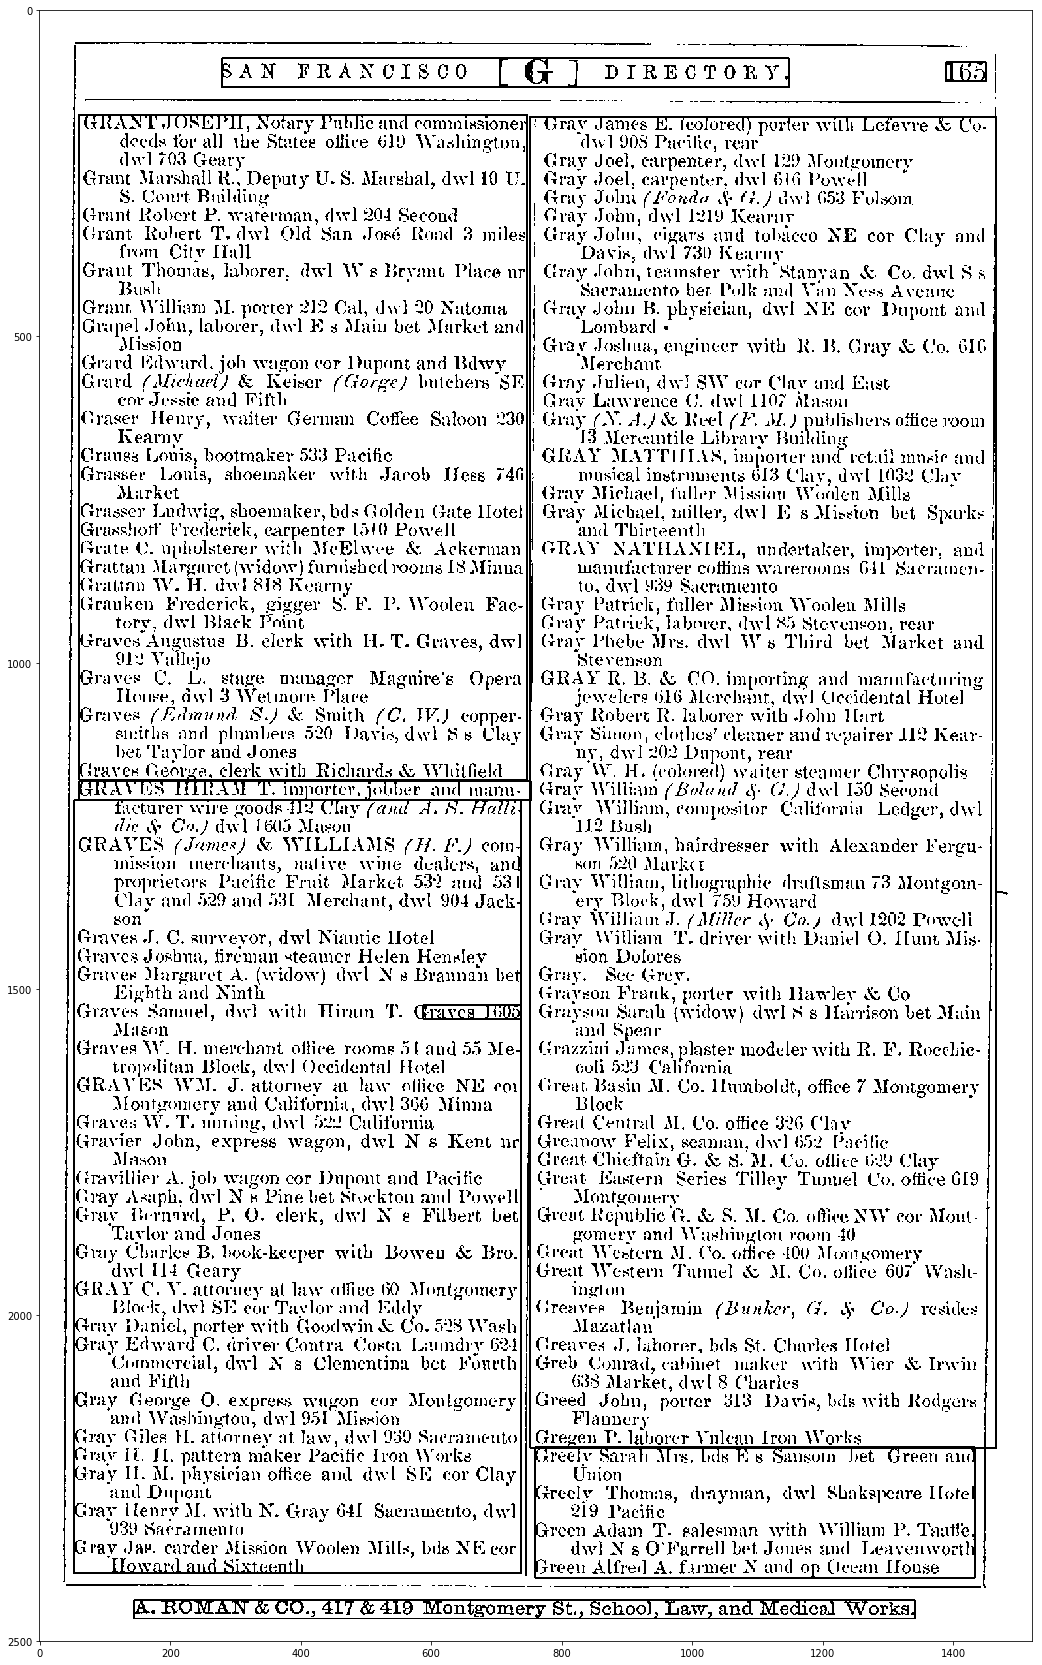

In [160]:
#wandImage(all_pages.sequence[81])

pagenum = 250

with wandImage(all_pages.sequence[pagenum]) as img:
    img.format = "png"
    img.alpha_channel = False
    img_buffer=np.asarray(bytearray(img.make_blob()), dtype=np.uint8)

if img_buffer is not None:
    retval = cv2.imdecode(img_buffer, cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(retval, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#if preprocess == "thresh":
gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

#elif preprocess == "blur":
#    gray = cv2.medianBlur(gray, 3)

blockstats = pagecontents[pagenum]['blockstats']

h, w = gray.shape
img_blocks = gray.copy()
for index, row in blockstats.iterrows():
    top_left = (row['left_at'], row['top_at'])
    bottom_right = (row['right_at'], row['bottom_at'])
    img_blocks = cv2.rectangle(img_blocks, top_left, bottom_right, (0, 255, 0), 2)

# show the output image with block bounding boxes
plt.imshow(img_blocks,cmap='gray')
plt.show()


In [178]:
type(gray)

numpy.ndarray

In [67]:
isdirectory = [False]*len(all_pages.sequence)
for i in range(124, 469):
    isdirectory[i] = True

In [75]:
def showpage(all_pages, pagenum):

    page = wandImage(all_pages.sequence[pagenum])
    with wandImage(page) as img:
        img.format = 'png'
        image_filename = 'temp.png'
        img.save(filename=image_filename)

        image = cv2.imread(image_filename)

    plt.rcParams["figure.figsize"] = (50,30)
    
    blockstats = pagecontents[pagenum]['blockstats']

    # draw the bounding boxes on the image
    h, w = gray.shape
    img_blocks = image.copy()
    for index, row in blockstats.iterrows():
        top_left = (row['left_at'], row['top_at'])
        bottom_right = (row['right_at'], row['bottom_at'])
        img_blocks = cv2.rectangle(img_blocks, top_left, bottom_right, (0, 255, 0), 2)

    # show the output image with block bounding boxes
    plt.imshow(img_blocks,cmap='gray')
    plt.show()
    
    return True

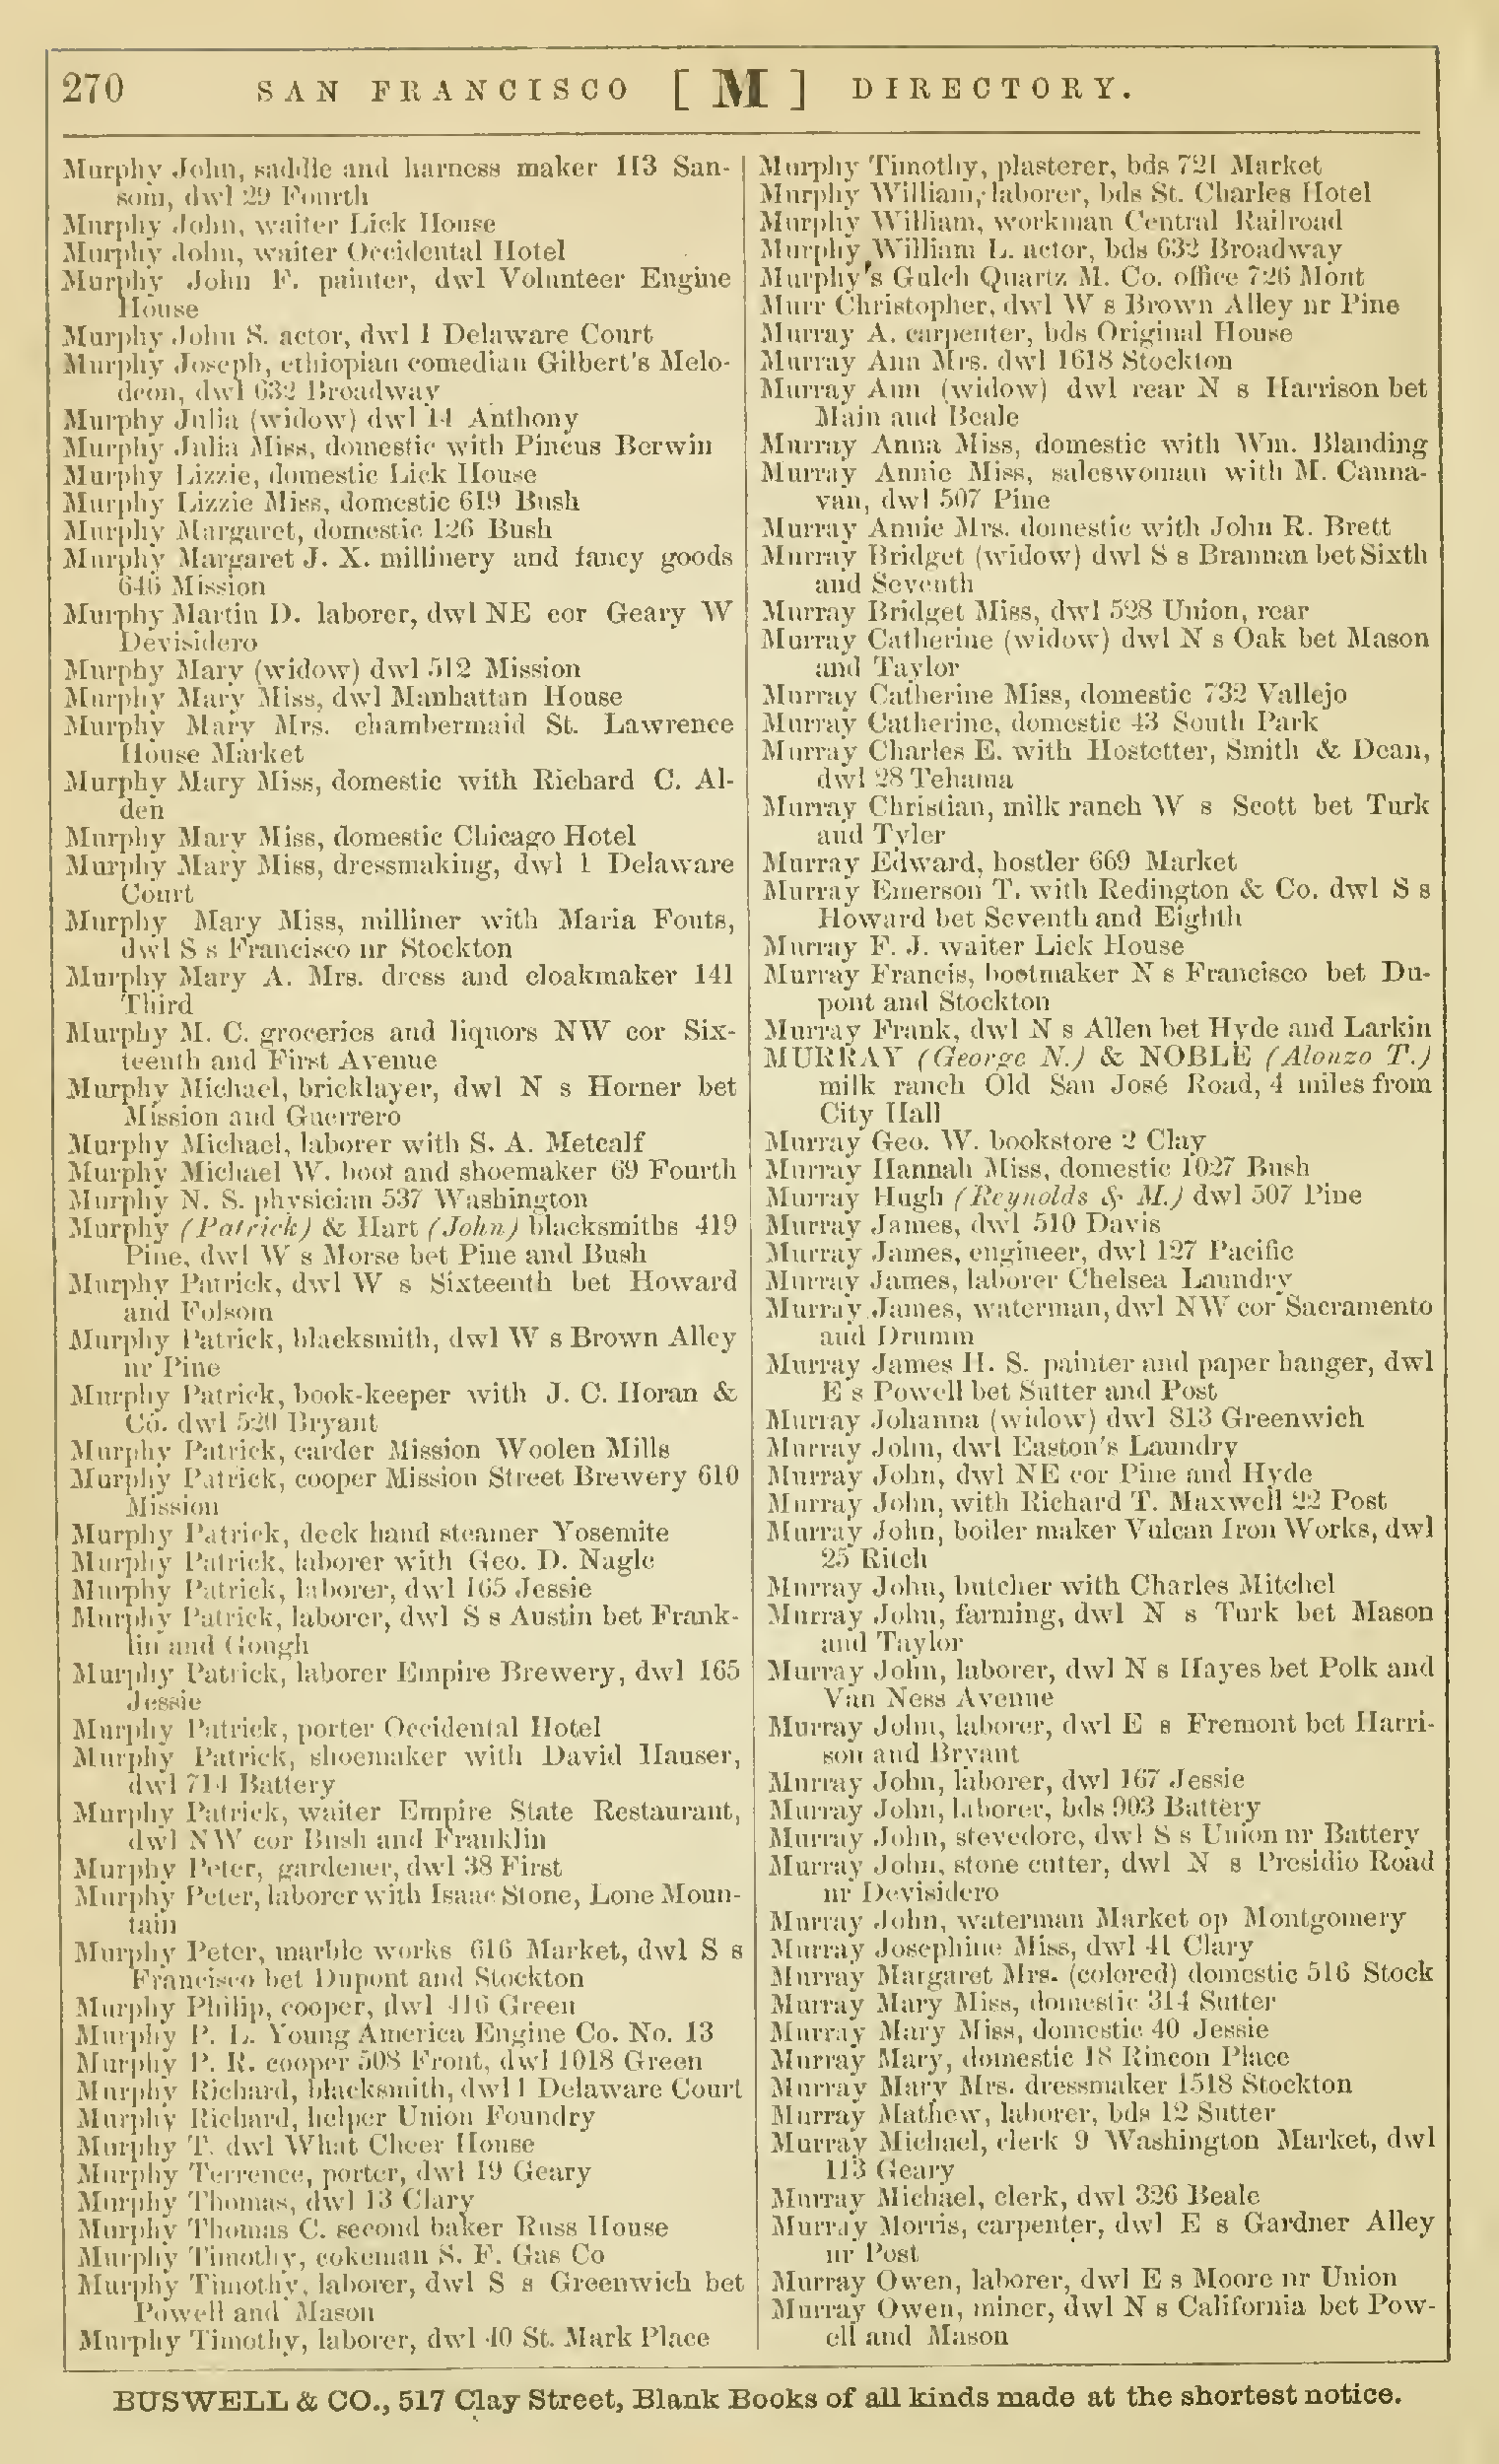

In [168]:
wandImage(all_pages.sequence[355])

In [181]:
type(img_blocks)

numpy.ndarray

In [165]:
pagecontents[250]

{'blockstats':        n_par  n_line  top_at  bottom_at  left_at  right_at
 block                                                     
 2          1       5      73        118      280      1148
 3          1       1      79        109     1389      1450
 4         22     211     160       1180       61       747
 5          1       8    1182       1211       61       753
 6         23     270    1211       2396       53       738
 7          1       2    1525       1546      588       737
 8         47     436     163       2203      752      1466
 11         4      43    2202       2403      759      1433
 12         1      14    2437       2465      145      1341,
 'paragraphs': {2: ['SAN FRANCISCO [ G@] DIRECTORY.'],
  3: ['1 6 5'],
  4: ['GRANT JOSEPH, Notary Public and comnnissioner deeds for all the States office 619 Washington, dw] 703 Geary',
   'Grant Marshall R., Deputy U.S. Marshal, dw1 10 U. S. Court Building',
   'Grant Robert P. waterman, dw] 204 Second',
   'Grant Robert

In [179]:
gray

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

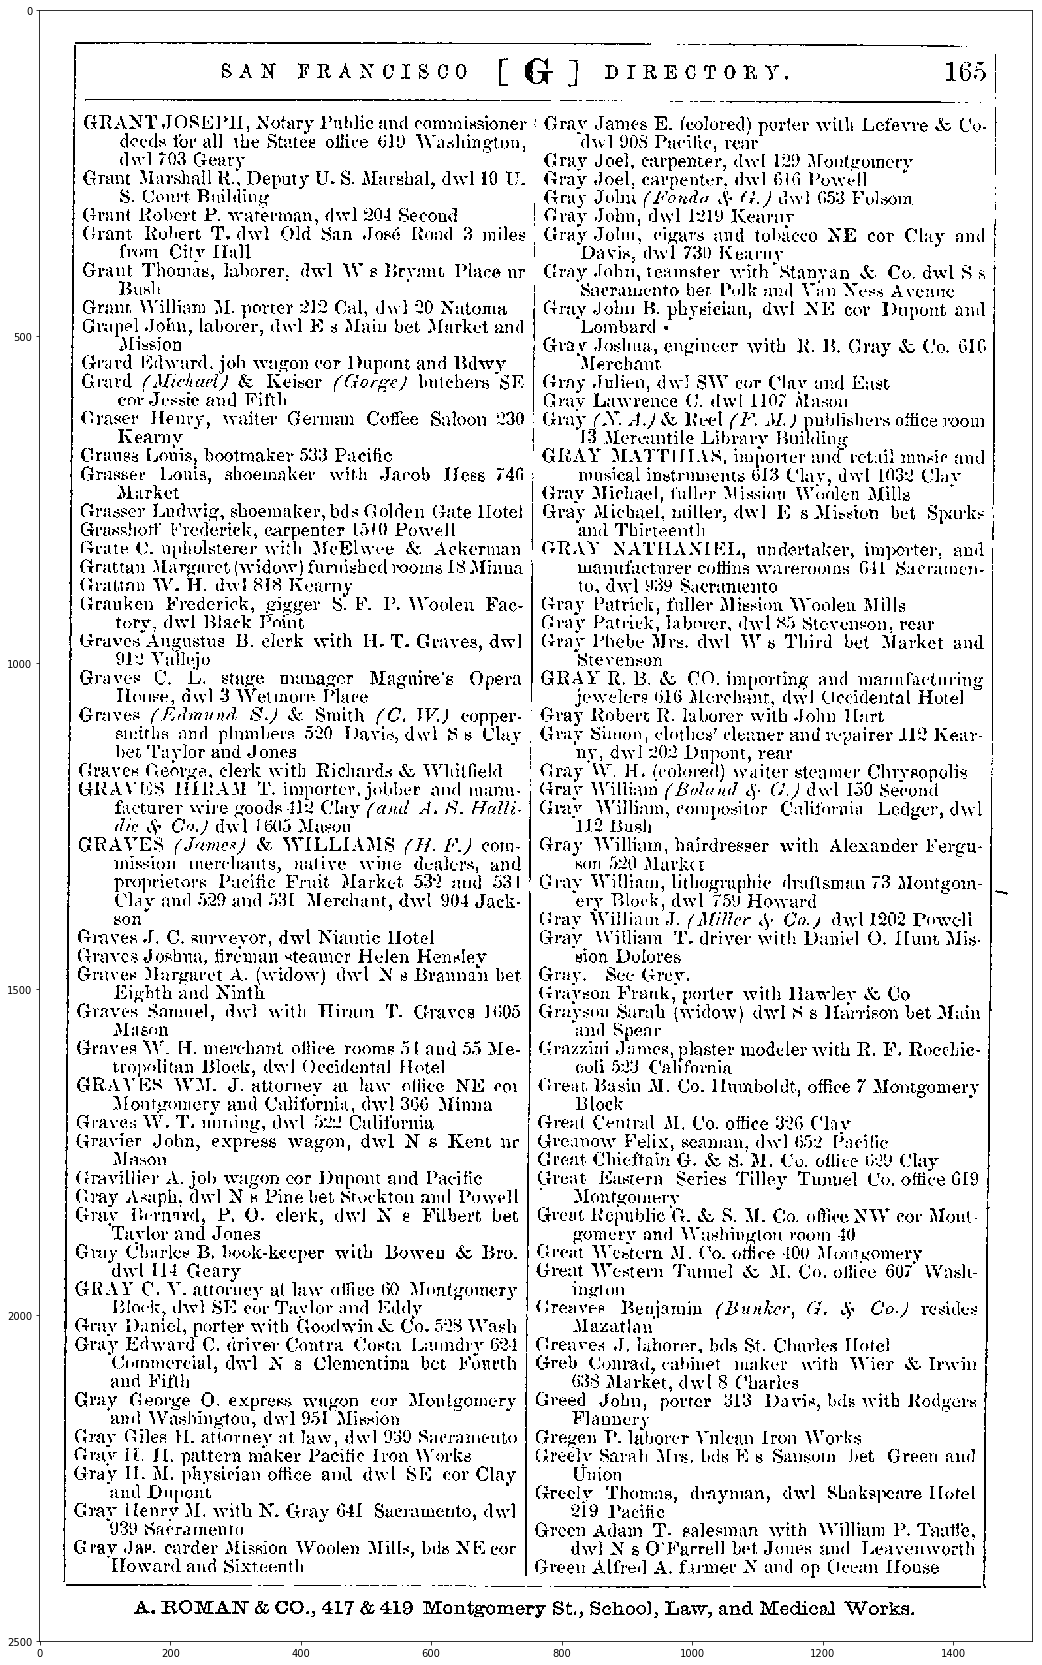

In [180]:
plt.imshow(gray, cmap="gray")